# First Transfer Learning Example - Benjamin Wilke

https://cs231n.github.io/transfer-learning/

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://medium.com/@tsakunelsonz/adding-custom-made-images-using-data-loaders-for-transfer-learning-in-five-steps-9d879bb5b80e

https://medium.com/@tsakunelsonz/loading-and-training-a-neural-network-with-custom-dataset-via-transfer-learning-in-pytorch-8e672933469

https://medium.com/swlh/image-classification-tutorials-in-pytorch-transfer-learning-19ebc329e200

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from collections import OrderedDict  # used to preserve ordering when passing dict to nn.Sequential()

############################## THIS IS TO RESOLVE ENVIRONMENT ISSUES...NEED TO REMOVE ONCE MIGRATED TO COLAB 
############ This should only be a Mac OS X problem
# https://github.com/dmlc/xgboost/issues/1715
os.environ['KMP_DUPLICATE_LIB_OK']='True'

############# Also needed to downgrade Pillow python package from 6.0 to 5.4.1 otherwise some of the images error
# https://github.com/python-pillow/Pillow/issues/3769

## Setup DataSets (ImageFolder), Transforms(), and DataLoader()

In [2]:
# Data augmentation and normalization for training; Just normalization for validation
data_transforms = {
    'train': transforms.Compose([                   # used to "compose" several transforms together
        transforms.RandomResizedCrop(224),          # crop random, aspect ratio random, output 224*224
        transforms.RandomHorizontalFlip(),          # horizontally flip image randomly with prob .5 (default)
        transforms.ToTensor(),                      # convert to tensornormak
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])    # normalize pre-computed means & STDs
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),     # force resize. If size is a sequence like (h, w), output size will be matched to this. If size is an int, smaller edge of the image will be matched to this number. i.e, if height > width, then image will be rescaled to (size * height / width, size)
        transforms.CenterCrop(224), # crop out of center
        transforms.ToTensor(),      # convert to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])    # normalize pre-computed means & STDs
    ]),
}

# set data directory to root of this notebook
data_dir = 'hymenoptera_data'

# instantiate torch device object; check for cuda (will be set type="cpu" on my machine)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transforms

{'train': Compose(
     RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
     RandomHorizontalFlip(p=0.5)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ), 'val': Compose(
     Resize(size=256, interpolation=PIL.Image.BILINEAR)
     CenterCrop(size=(224, 224))
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

In [3]:
# does environment support CUDA GPU
if torch.cuda.is_available():
    print("GPU/CUDA is available.")
else:
    print("GPU/CUDA unavailable, running on CPU")
    
device

GPU/CUDA unavailable, running on CPU


device(type='cpu')

In [4]:
# initialize the datasets dictionary
# call ImageFolder method each for "train" and "val"
# creates a dictionary with keys "train" and "val" with instantiate object for each
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])  # passes our data transforms dictionary from above
                  for x in ['train', 'val']}

image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [5]:
# more on DataLoader: https://medium.com/@tsakunelsonz/adding-custom-made-images-using-data-loaders-for-transfer-learning-in-five-steps-9d879bb5b80e
# instantiate dataloaders into a dictionary of train/val
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x10a9584e0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x11781e080>}

In [6]:
# save and print dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes

{'train': 244, 'val': 153}

In [7]:
# save and print class_names, also set encoder and decoder
class_names = image_datasets['train'].classes

#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(class_names)):
    decoder[class_names[i]] = i
encoder = {}
for i in range(len(class_names)):
    encoder[i] = class_names[i]

class_names

['ants', 'bees']

## Visualize Images from Data Set

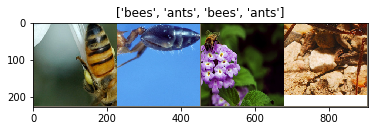

In [8]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])            # since the images were normalized in transforms
    std = np.array([0.229, 0.224, 0.225])             # they need to be reverse normalized here
    inp = std * inp + mean                            # these are
    inp = np.clip(inp, 0, 1)                          # doing the same thing as the inv_normalize() function below
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data and their classes 
inputs, classes = next(iter(dataloaders['train']))     # this is 4 images because batch size is 4


out = torchvision.utils.make_grid(inputs)              # Make a grid from batch
imshow(out, title=[class_names[x] for x in classes])   # form title list comprehension of titles, show grid image

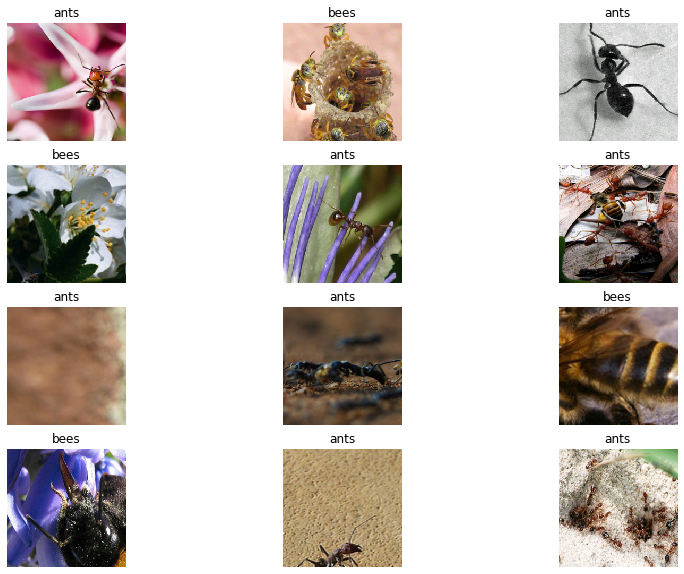

In [12]:
# Here's another set of functions that may come in handy for visualization.
# https://medium.com/swlh/image-classification-tutorials-in-pytorch-transfer-learning-19ebc329e200
#
# these were the normalizations set on this particular dataset in Setup above
# transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# this function is used to reverse them to display images correctly.
inv_normalize =  transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def class_plot(data, encoder, inv_normalize, n_figures = 12):
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():                               # for each position in grid
        a = random.randint(0,len(data))                     # get random number from length data     
        (image,label) = data[a]                             # load image, label tuple from random index  
        label = int(label)                                  # convert label to int
        l = encoder[label]                                  # get string from label encoder index
        image = inv_normalize(image)                        # run our inverse normalization
        image = image.numpy().transpose(1,2,0)          
        im = ax.imshow(image)                               # set position in grid to current image
        ax.set_title(l)                                     # set title to label string
        ax.axis('off')
    plt.show()

# run our class plot function, passing in training data, our label encoder, and inverse normalization
class_plot(image_datasets['train'], encoder, inv_normalize)

## Define the train_model() Function

In [13]:
# https://medium.com/@tsakunelsonz/loading-and-training-a-neural-network-with-custom-dataset-via-transfer-learning-in-pytorch-8e672933469
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, loader, optimizer, scheduler, criterion, epochs):
    gpu = False                                # will need to accomodate for this once in GPU/CUDA environment
    since = time.time()                        # start the clock
    best_model_wts = copy.deepcopy(model.state_dict())  # deep copy current model, pretrained and empty added layers
    best_acc = 0.0                             # initialize best accuracy to track all epochs accuracy
    epoch = 0                                  # initialize epoch counter
    for e in range(epochs):                    # loop through epochs
        epoch +=1                              # increment epoch
############################################################## TRAINING PHASE ################
        print("Training Epoch: {}".format(epoch))
        model.train()                          # switch to training mode
        current_loss = 0
        current_correct = 0
        for train, y_train in iter(loader["train"]): # iterate on DataLoader for training
            if gpu:                                  # train.to and y_train.to are defaulted to CPU
                train, y_train = train.to('cuda'), y_train.to('cuda') # if GPU then use GPU not CPU, via to() method
            optimizer.zero_grad()                    # initialize optimizer gradients to zero
            with torch.set_grad_enabled(True):       # set gradients enabled flag for training
                output = model.forward(train)        # feed forward the training instance
                _, preds = torch.max(output,1)
                loss = criterion(output, y_train)    # calculate cross entropy loss
                loss.backward()                      # calculate gradients via back propagate the gradients
                optimizer.step()                     # parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule.
            current_loss += loss.item()*train.size(0)              # calculate current loss
            current_correct += torch.sum(preds == y_train.data)    # calculate current accuracy
    
        epoch_train_loss = current_loss / len(loader["train"].dataset)            # calculate epoch loss
        epoch_train_acc = current_correct.double() / len(loader["train"].dataset) # calculate epoch accuracy
        print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch, epoch_train_loss, epoch_train_acc))        
        scheduler.step()                               # update LR decay in scheduler per epoch of training
############################################################## VALIDATION PHASE ################
        
        model.eval()                           # switch to evaluation mode
        valid_loss = 0
        valid_correct = 0
        for valid, y_valid in iter(loader["val"]): # iterate on DataLoader for validation
            if gpu:
                valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
            with torch.no_grad():                  # set gradients enabled flag for validation
                output = model.forward(valid)      # feed forward the validation instance
            valid_loss += criterion(output, y_valid).item()*valid.size(0)
            equal = (output.max(dim=1)[1] == y_valid.data)
            valid_correct += torch.sum(equal)  #type(torch.FloatTensor)
    
        epoch_val_loss = valid_loss / len(loader["val"].dataset)
        epoch_val_acc = valid_correct.double() / len(loader["val"].dataset)
        print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch, epoch_val_loss, epoch_val_acc))
        
        # if current epoch validation accuracy is greatest yet, deep copy the model parameters      
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc  
            best_model_wts = copy.deepcopy(model.state_dict())
                                                                           
    # get time elapsed and print    
    time_elapsed = time.time() - since                     
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_acc))
        
    # load best model weights and return them
    model.load_state_dict(best_model_wts)
    return model    

## Investigate Model Architecture of Original VGG-16

In [14]:
model_inspect = models.vgg16(pretrained = True)    # get the pretrained model (vgg16 in this case)
print(model_inspect)                               # print model architecture

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Transfer Model 1 :: VGG-16, Freeze, Replace Final Classifier Layers with Single Layer

In [15]:
model_freeze_single = models.vgg16(pretrained = True) # get the pretrained model (vgg16 in this case)

for param in model_freeze_single.parameters():          # freeze parameters, prevent gradients from being calculated
    param.require_grad = False

num_ftrs = model_freeze_single.classifier[0].in_features              # get number of features coming into first FC layer of pretrained model
model_freeze_single.classifier = nn.Linear(num_ftrs, len(class_names))# replace final layer with inputs from existing, outputs to new classes

print(model_freeze_single)                                            # print model architecture

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# instantiate cross-entropy loss
criterion = nn.CrossEntropyLoss()                           
# instantiate SGD optimizer - NOTE ONLY FULLY CONNECTED LAYERS (all classifier)
optimizer = optim.SGD(model_freeze_single.classifier.parameters(), lr = 0.001, momentum = 0.9)
# instantiate Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) 

In [17]:
model_freeze_single = train_model(model_freeze_single, dataloaders, optimizer, exp_lr_scheduler, criterion, 2) 

Training Epoch: 1
Epoch: 1 Train Loss : 2.1302  Train Accuracy: 0.8115
Epoch: 1 Validation Loss : 2.3254  Validation Accuracy 0.8889
Training Epoch: 2
Epoch: 2 Train Loss : 0.9912  Train Accuracy: 0.8934
Epoch: 2 Validation Loss : 2.4067  Validation Accuracy 0.9216
Training complete in 31m 17s
Best Validation Accuracy: 0.921569


## Transfer Model 2 :: VGG-16, Freeze, Replace Final Classifier Layers with New Architecture

In [18]:
model_freeze_arch = models.vgg16(pretrained = True)   # get the pretrained model (vgg16 in this case)

for param in model_freeze_arch.parameters():          # freeze parameters, prevent gradients from being calculated
    param.require_grad = False
    
# by modifying the classifier of the loaded NN with a new classifier, adapted to our datasets structure,
# mainly in terms of the dataset’s input feature size and expected output size. The following code snippet
# creates a classifier for our custom dataset, and is then added to the loaded vgg-16 model.

num_ftrs = model_freeze_arch.classifier[0].in_features                  # get number of features coming into first FC layer of pretrained model

# create multilayer classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(num_ftrs, 1000)),# FC layer, input size specific to vgg16
                           ('relu', nn.ReLU()),                            # apply relu
                           ('dropout', nn.Dropout(p=0.337)),               # apply dropout
                           ('fc2', nn.Linear(1000, len(class_names))),     # FC layer, input size 512 from fc1, output size is number of classes
                           ('output', nn.LogSoftmax(dim=1))                # Softmax
                            ]))

model_freeze_arch.classifier = classifier              # replace the model's classifier with this new classifier
print(model_freeze_arch)                              # print model architecture

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
# instantiate SGD optimizer - NOTE ONLY FULLY CONNECTED LAYERS (all classifier), NOT FULL ARCHITECTURE
optimizer = optim.SGD(model_freeze_arch.classifier.parameters(), lr = 0.001, momentum = 0.9)
# instantiate Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
model_freeze_arch = train_model(model_freeze_arch, dataloaders, optimizer, exp_lr_scheduler, criterion, 1) 

Training Epoch: 1
Epoch: 1 Train Loss : 0.3886  Train Accuracy: 0.8443
Epoch: 1 Validation Loss : 0.3257  Validation Accuracy 0.9412
Training complete in 6m 48s
Best Validation Accuracy: 0.941176


## Transfer Model 3 :: VGG-16, Fine Tune (Unlocked), Replace Final Classifier Layers with New Architecture

In [21]:
model_tune_multi = models.vgg16(pretrained = True)       # get the pretrained model (vgg16 in this case)
num_ftrs = model_tune_multi.classifier[0].in_features    # get number of features coming into first FC layer of pretrained model

# note that we are not freezing parameters and preventing gradients from being calculated
# by setting param.require_grad = False

# create multilayer classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(num_ftrs, 1000)),# FC layer, input size specific to vgg16
                           ('relu', nn.ReLU()),                            # apply relu
                           ('dropout', nn.Dropout(p=0.337)),               # apply dropout
                           ('fc2', nn.Linear(1000, len(class_names))),     # FC layer, input size 512 from fc1, output size is number of classes
                           ('output', nn.LogSoftmax(dim=1))                # Softmax
                            ]))

model_tune_multi.classifier = classifier              # replace the model's classifier with this new classifier
print(model_tune_multi)                               # print model architecture

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
# instantiate SGD optimizer - NOTE ALL MODEL PARAMETERS (FULL MODEL, NOT ONLY THE CLASSIFIER)
optimizer = optim.SGD(model_tune_multi.parameters(), lr = 0.001, momentum = 0.9)
# instantiate Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [25]:
model_tune_multi = train_model(model_tune_multi, dataloaders, optimizer, exp_lr_scheduler, criterion, 1) 

Training Epoch: 1
Epoch: 1 Train Loss : 0.4728  Train Accuracy: 0.8238
Epoch: 1 Validation Loss : 0.2566  Validation Accuracy 0.9150
Training complete in 6m 50s
Best Validation Accuracy: 0.915033


## Testing the Modified Networks

In [40]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()                          # switch to evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():                 # lock parameters, and gradient calc
        for i, (inputs, labels) in enumerate(dataloaders['val']):    # iterate over the validation set
            inputs = inputs.to(device)                               # set computation device
            labels = labels.to(device)                               # set computation device

            outputs = model(inputs)                                  # feed forward inputs
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):                        # for each image in batch
                images_so_far += 1                                   # increment for each image
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # updated this to below to calculate predicted and actual using our encoder dictionary
                ax.set_title('pred: {0}, actual: {1}'.format(class_names[preds[j]], encoder[int(labels[j])]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

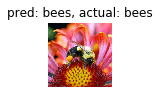

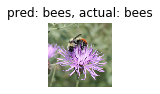

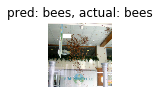

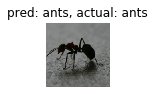

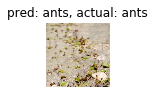

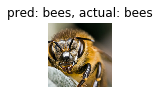

In [41]:
visualize_model(model_freeze_arch)

In [49]:
# https://medium.com/swlh/image-classification-tutorials-in-pytorch-transfer-learning-19ebc329e200
# Some more functions for testing, performing, and insights to add


In [ ]:
# performance stats

In [ ]:
# confusion matrix

## Predict Single Image Input and Provide Class Confidence

## Get the Mean and Standard Deviation of Dataset for Normalization

In [ ]:
# We'll need this once we have custom image sets to input into the DataLoader transforms.
# Looks like it needs some work as well....we might even think about setting these globally once we have
# the final dataset, because they're needed to inverse for visualization as well.
#
# https://medium.com/swlh/image-classification-tutorials-in-pytorch-transfer-learning-19ebc329e200
mean = 0.
std = 0.
nb_samples = len(data)
for data,_ in dataloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
mean /= nb_samples
std /= nb_samples